In [1]:

import numpy as np
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as utils

#E(2)-steerable CNNs - librar"y:
from e2cnn import gspaces    
from e2cnn import nn as G_CNN   
import e2cnn

#Plotting in 2d/3d:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.patches import Ellipse
from matplotlib.colors import Normalize
import matplotlib.cm as cm

#Tools:
import datetime
import sys
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

sys.path.append('../../')
#Own files:
import Kernel_and_GP_tools as GP
import My_Tools
import EquivDeepSets 
import Training
from Cov_Converter import cov_converter
import Decoder_Models as models
import Architectures
import EquivCNP
import Tasks.GP_Data.GP_div_free_circle.loader as DataLoader

#HYPERPARAMETERS and set seed:
torch.set_default_dtype(torch.float)

In [78]:
def give_cyclic_div_free(max_radius=2,n_centers=1,l_scale=1.,n_axis=30,sigma_var=1.):
    X_Grid=My_Tools.Radial_Grid(min=-2,max=2,n_axis=n_axis)
    Y=torch.zeros(X_Grid.shape)
    for i in range(n_centers):
        r=np.random.uniform(low=0.0,high=max_radius)
        theta=np.random.uniform(low=0.0,high=2*np.pi)
        X_0=torch.tensor([r*np.cos(theta),r*np.sin(theta)],dtype=torch.get_default_dtype())
        Gram=GP.Gram_matrix(X_Grid,X_0.unsqueeze(0),kernel_type="div_free",l_scale=l_scale,sigma_var=sigma_var)
        rand_vec=torch.randn(size=[2,1])
        Y+=torch.matmul(Gram,rand_vec).view(-1,2)
    return(X_Grid,Y)

In [276]:
#Quiver: scale - data units per arrow length unit
def plot_context_and_VF(ax,X_Context=None,Y_Context=None,X_Target=None,Y_Target=None,scale=20):
    if X_Target is not None and Y_Target is not None:
        ax.quiver(X_Target[:,0],X_Target[:,1],Y_Target[:,0],Y_Target[:,1],
        color='tab:blue',pivot='mid',scale_units='width',scale=scale,headlength=4, headwidth = 2,width=0.005,alpha=1)
    if X_Context is not None and Y_Context is not None:
        ax.quiver(X_Context[:,0],X_Context[:,1],Y_Context[:,0],Y_Context[:,1],
            color='firebrick',pivot='mid',label='Context set',scale_units='width',scale=scale,headlength=4, headwidth = 2,width=0.005)   
    ax.set_facecolor('peachpuff')
    return(ax)

def compare_VF(ax,X_Context=None,Y_Context=None,X_Target=None,Predict_1=None,Predict_2=None,label_1='',label_2='',scale=20):
    if X_Target is not None and Y_Target is not None:
        ax.scatter(X_Target[:,0],X_Target[:,1],Y_Target[:,0],Y_Target[:,1],
        color='firebrick')
    if Predict_1 is not None:
        ax.quiver(X_Target[:,0],X_Target[:,1],Predict_1[:,0],Predict_1[:,1],
            color='tab:blue',pivot='mid',label='Predict',scale_units='width',scale=scale,headlength=4, headwidth = 2,width=0.005) 
    if Predict_2 is not None:
        ax.quiver(X_Target[:,0],X_Target[:,1],Predict_2[:,0],Predict_2[:,1],
            color='tab:blue',pivot='mid',label='Predict',scale_units='width',scale=scale,headlength=4, headwidth = 2,width=0.005) 



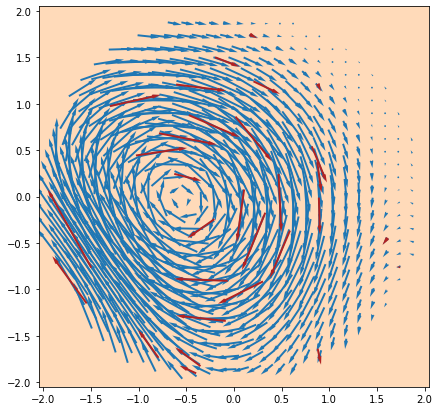

In [277]:
fig,ax=plt.subplots(nrows=1,ncols=1,figsize=(7,7))
X_Target,Y_Target=give_cyclic_div_free(n_centers=4)
ind=torch.randperm(X_Target.size(0))[:30]
X_Context=X_Target[ind]
Y_Context=Y_Target[ind]+0.2*torch.randn(X_Context.shape)
ax=plot_context_and_VF(ax,X_Context,Y_Context,X_Target,Y_Target)
ax.set_facecolor('peachpuff')

In [ ]:
def Plot_Inference_2d(X_Context,Y_Context,X_Target=None,Y_Target=None,Predict=None,Cov_Mat=None,title="",size_scale=2, ellip_scale=0.8,quiver_scale=15,plot_points=False):
    '''
    Inputs: X_Context,Y_Context: torch.tensor - shape (n_context_points,2) - given context set
            X_Target,Y_Target: torch.tensor - shape (n_target_points,2) - target locations and outputs vectors 
            Predict: torch.tensor - shape (n_target_points,2) - target predictions (i.e. predicting Y_Target)
            Cov_Mat: torch.tensor - shape (n_target_points,2,2) - set of covariance matrices
                                  or - shape (n_target_points,2) - set of variances 
            title: string -  suptitle
    Outputs: None - plots the above tensors in two plots: one plots the means against the context sets, the other one the covariances/variances
    '''
    #Create plots:
    fig, ax = plt.subplots(nrows=1,ncols=2,figsize=(size_scale*10,size_scale*5))
    plt.gca().set_aspect('equal', adjustable='box')
    fig.subplots_adjust(wspace=0.4)
    #Set titles:
    fig.suptitle(title)
    ax[0].set_title("Context set and predictions")
    ax[1].set_title("Variances")
    
    #Plot context set in blue:
    if plot_points:
        ax[0].scatter(X_Context[:,0],X_Context[:,1],color='black')
    if X_Context is not None and Y_Context is not None:
        ax[0].quiver(X_Context[:,0],X_Context[:,1],Y_Context[:,0],Y_Context[:,1],
        color='black',pivot='mid',label='Context set',scale=quiver_scale)
    
    #Plot ground truth in red if given:
    if Y_Target is not None and X_Target is not None:       
        ax[0].quiver(X_Target[:,0],X_Target[:,1],Y_Target[:,0],Y_Target[:,1],
          color='blue',pivot='mid',label='Ground truth',scale=quiver_scale)
    
    #Plot predicted means in green:
    if  Predict is not None and X_Target is not None:
        ax[0].quiver(X_Target[:,0],X_Target[:,1],Predict[:,0],Predict[:,1],color='red',pivot='mid',label='Predictions',scale=quiver_scale)

    leg = ax[0].legend(bbox_to_anchor=(1., 1.))
    
    if X_Target is not None and Cov_Mat is not None:
        #Get window limites for plot and set window for second plot:
        ax[1].set_xlim(ax[0].get_xlim())
        ax[1].set_ylim(ax[0].get_ylim())
        ax[1].scatter(X_Context[:,0],X_Context[:,1],color='black',label='Context Points',marker='+')
        #Go over all target points and plot ellipse of continour lines of density of distributions:
        for j in range(X_Target.size(0)):
            #Get covarinace matrix:
            A=Cov_Mat[j]
            if len(A.size())==1:
                A=torch.diag(A)
            
            #Decompose A:
            eigen_decomp=torch.eig(A,eigenvectors=True)
            #Get the eigenvector corresponding corresponding to the largest eigenvalue:
            u=eigen_decomp[1][:,0]

            #Get the angle of the ellipse in degrees:
            alpha=360*torch.atan(u[1]/u[0])/(2*math.pi)
        
            #Get the width and height of the ellipses (eigenvalues of A):
            D=torch.sqrt(eigen_decomp[0][:,0])
        
            #Plot the Ellipse:
            E=Ellipse(xy=X_Target[j,].numpy(),width=ellip_scale*D[0],height=ellip_scale*D[1],angle=alpha)
            ax[1].add_patch(E)
            
        #Create a legend:
        blue_ellipse = Ellipse(color='c', label='Confid. ellip.',xy=0,width=1,height=1)
        ax[1].legend(handles=[blue_ellipse])
        leg = ax[1].legend(bbox_to_anchor=(1., 1.))